In [139]:
import numpy as np 
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from nets import Nets
from utils import *

import re

from sklearn.cluster import DBSCAN


from postprocessing import *
from analysis import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [705]:
def interpolate_models(model1, model2, beta):
    params1 = model1.named_parameters()
    params2 = model2.named_parameters()

    dict_params2 = dict(params2)

    for name1, param1 in params1:
        if name1 in dict_params2:
            dict_params2[name1].data.copy_((1-beta)*param1.data + beta*dict_params2[name1].data)

    return model2

def get_loss_grad(net, criterion, data):
        inputs, labels = data

        # Compute gradients for input.
        inputs.requires_grad = True

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs.float(), labels)
        loss.backward(retain_graph=True)
        
        param_grads = get_grad_params_vec(net)
        return loss, torch.norm(param_grads)

def get_model_interpolate_arr(model_a, model_b, criterion, data, num_inter_models):
    

    
    inter_models_arr = []
    inter_loss_grad_arr = []
    
    betas = np.linspace(0, 1, num_inter_models)
    for beta in betas:
        curr_model = copy.deepcopy(model_b)
        curr_model = interpolate_models(model_a, curr_model, beta)
        curr_loss, curr_grad = get_loss_grad(curr_model, criterion, data)
        
        inter_models_arr.append(curr_model)
        inter_loss_grad_arr.append([curr_loss, curr_grad])
        
    return inter_models_arr, np.array(inter_loss_grad_arr)

def _take_n_gd_steps(net, optimizer, criterion, data, n=1):
        for _ in range(n):
        
            inputs, labels = data

            # Compute gradients for input.
            inputs.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs.float(), labels)
            loss.backward(retain_graph=True)
            optimizer.step()
        
        return net

def do_the_do(model, optimizer, criterion, data_loader, num_inter_models):
    
    data = next(iter(data_loader))
    
    model_a = copy.deepcopy(model)
    model_b = _take_n_gd_steps(model, optimizer, criterion, data)
    
    return get_model_interpolate_arr(model_a, model_b, criterion, data, num_inter_models)

exp_id = "1589992134.56161"


# get data
train_data, test_data = get_postprocessing_data(experiment_folder, vectorized=True)
train_loader = DataLoader(train_data, batch_size=10000, shuffle=True)  # fix the batch size
test_loader = DataLoader(test_data, batch_size=len(test_data))


criterion = torch.nn.CrossEntropyLoss()
cfs_dict = exp_dict["stuff"]["configs"].loc[exp_id].to_dict()
nets = get_nets(cfs_dict)
optimizers = get_optimizers(cfs_dict)(nets)
inter_nets = []
for nn_idx in range(len(nets)):
    inter_nets.append(do_the_do(nets[nn_idx], optimizers[nn_idx], criterion, train_loader, 20))

Files already downloaded and verified
Files already downloaded and verified


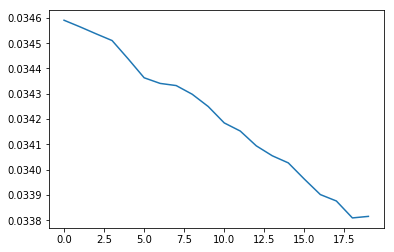

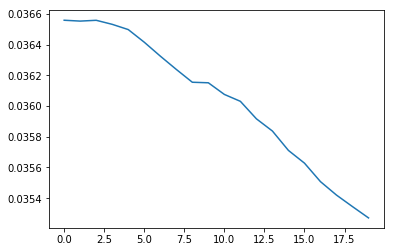

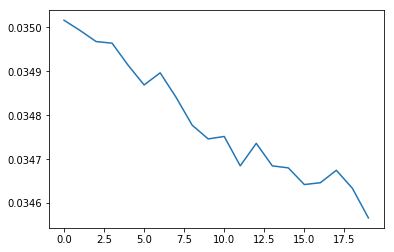

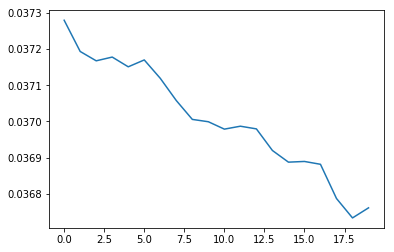

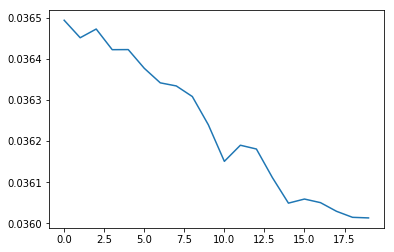

In [708]:
for nn_index in range(len(nets)):
    y_val = inter_nets[nn_index][1][:, 1]
    plt.plot(list(range(len(y_val))), y_val)
    plt.show()

In [690]:
inter_nets[0][1]

array([[tensor(2.3013, grad_fn=<NllLossBackward>), tensor(0.0820)]],
      dtype=object)

In [3]:
exp_root = "/Users/daniellengyel/flat_sharp/flat_sharp/experiments/{}" #"/Users/daniellengyel/flat_sharp/gaussian/gaussian_experiments/Apr03_17-38-00_Daniels-MacBook-Pro-4.local"
# configs = get_configs(experiment_folder)

In [174]:
# get all sorts of data
exp_dict = {}

experiment_folder = exp_root.format("MNIST/May21_04-34-11_Daniels-MacBook-Pro-4.local") #Apr27_00-03-27_Daniels-MacBook-Pro-4.local
exp_dict["stuff"] = get_stuff(experiment_folder)
exp_dict["models"] = get_all_models(experiment_folder, -1)
# exp_dict["resampling_idxs"] = get_sample_idxs(experiment_folder)

Getting tsne.
Error: tsne could not be found
Getting runs.
Getting trace.
Getting acc.
Getting dist.
Error: dist could not be found
Getting loss.
Error: loss could not be found


In [175]:
stats_df = get_end_stats(exp_dict["stuff"])
# stats_df = stats_df[stats_df["Mean Train Loss"] < 0.25]
stats_df.sort_values(by="Test Acc Mean", ascending=False)

Error: No runs for 1590056201.264468
Error: No trace for 1590056201.264468
Error: No runs for 1590060331.36747
Error: No trace for 1590060331.36747
Error: No runs for 1590061232.082815
Error: No trace for 1590061232.082815
Error: No runs for 1590059361.444496
Error: No trace for 1590059361.444496
Error: No runs for 1590054788.947242
Error: No trace for 1590054788.947242
Error: No runs for 1590059516.801294
Error: No trace for 1590059516.801294


/Users/daniellengyel/flat_sharp/flat_sharp/analysis.py:116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats_pd = pd.concat([stats_pd, cfs_hp_df], axis=1)


,Test Acc Max,Test Acc Mean,Test Acc Min,Test Acc/Trace Correlation,Trace Max,Trace Mean,Trace Mean Std,Trace Min,Train Loss Max,Train Loss Mean,Train Loss Min,Train Loss/Trace Correlation,batch_train_size,learning_rate,softmax_beta
1590053699.660497,0.9807,0.980135,0.9776,-0.422919,7.182803,6.091587,0.774739,5.457691,0.043149,0.009407,0.002074,0.028756,128,1.4678,-0.01
1590045173.231596,0.9804,0.979900,0.9796,-0.757671,11.822736,10.656929,1.549725,9.304502,0.027102,0.009748,0.003227,-0.145267,128,0.464159,-0.01
1590033973.8102221,0.9817,0.979610,0.9778,-0.331414,9.054777,7.540652,1.023714,6.842157,0.020478,0.009504,0.002439,-0.077140,128,1,0
1590035091.965398,0.9812,0.979455,0.9777,-0.529347,6.893168,5.976304,0.773099,5.548013,0.027875,0.009248,0.003390,0.691195,128,1.4678,0
1590028573.3593879,0.9804,0.979100,0.9775,-0.659670,10.493960,9.158624,1.235033,8.194385,0.020730,0.009103,0.002602,0.155887,128,0.681292,0
1590028570.450788,0.9807,0.979060,0.9772,-0.381470,16.380532,14.445750,2.383733,12.433991,0.026018,0.014685,0.006407,-0.082891,128,0.316228,0
1590045177.104209,0.9799,0.979015,0.9784,-0.430210,11.777955,10.076701,1.484066,9.265446,0.017043,0.009340,0.004989,0.288988,128,0.681292,-0.01
1590028572.1037078,0.9802,0.978965,0.9779,-0.043652,13.232570,11.627310,1.655454,10.099397,0.019672,0.009906,0.003923,-0.115267,128,0.464159,0
1590035144.78129,0.9805,0.978920,0.9765,-0.351663,5.711400,4.473414,0.562180,3.691441,0.028790,0.009549,0.001884,0.247429,128,2.15443,0
1590041496.330213,0.9793,0.978230,0.9767,-0.141006,19.696440,17.707805,3.129392,15.884404,0.066994,0.026746,0.009052,-0.137304,128,0.215443,-0.01


In [55]:
stats_df = get_end_stats(exp_dict["stuff"])
# stats_df = stats_df[stats_df["Mean Train Loss"] < 0.25]
stats_df.sort_values(by="Test Acc Mean", ascending=False)

,Dist Max,Dist Mean,Dist Min,Test Acc Max,Test Acc Mean,Test Acc Min,Test Acc/Trace Correlation,Trace Max,Trace Mean,Trace Mean Std,Trace Min,Train Loss Max,Train Loss Mean,Train Loss Min,Train Loss/Trace Correlation,learning_rate,softmax_beta
1589883398.313369,10.724253,10.561621,10.417041,0.9349,0.931865,0.9255,0.149511,32.093290,28.938671,5.850617,26.512523,0.369751,0.236457,0.135426,-0.041547,0.3,0
1589819540.132111,17.147022,16.777927,10.380927,0.9356,0.931690,0.9283,-0.341101,32.251222,29.660316,6.019527,26.727461,0.358914,0.229823,0.122797,-0.164844,0.3,100
1589814483.818634,17.174482,16.782592,10.413730,0.9339,0.931435,0.9295,-0.182137,33.113935,29.538561,6.540085,24.232054,0.374482,0.242563,0.133107,0.098097,0.3,-100
1589819533.973203,16.937157,16.562041,10.044470,0.9337,0.929760,0.9272,0.073881,33.895497,30.796315,6.867654,28.753331,0.369161,0.243789,0.131583,0.116342,0.267222,100
1589883397.665699,10.403640,10.246873,10.097101,0.9323,0.929100,0.9237,0.221389,33.610437,29.840405,5.770724,26.323593,0.379900,0.249423,0.145270,0.094609,0.267222,0
1589819531.7221708,16.749601,16.369544,9.736142,0.9311,0.926960,0.9236,0.134716,36.196227,32.491123,7.012821,29.161611,0.382298,0.254698,0.149498,-0.123945,0.234444,100
1589883397.124286,10.061064,9.908710,9.751584,0.9296,0.925790,0.9204,-0.000954,32.503111,29.248711,6.259045,26.570644,0.389413,0.264589,0.154874,-0.104180,0.234444,0
1589814481.3707871,17.125465,16.750440,10.384410,0.9279,0.925615,0.9234,0.072577,31.782335,28.842307,6.256193,26.550805,0.375790,0.256896,0.139798,0.228865,0.267222,-100
1589814477.723897,16.923988,16.544189,10.060768,0.9248,0.923510,0.9190,-0.557207,32.516130,29.351899,7.006947,26.074321,0.386315,0.269621,0.158848,0.265200,0.234444,-100
1589819526.893172,16.514524,16.133411,9.358477,0.9250,0.922450,0.9203,0.341229,37.079454,33.027920,6.635563,26.482865,0.404615,0.277193,0.163362,0.234144,0.201667,100


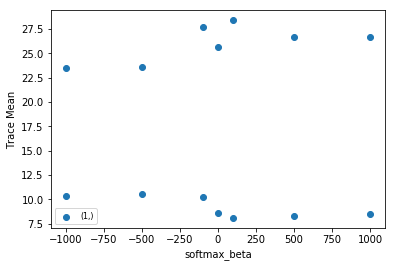

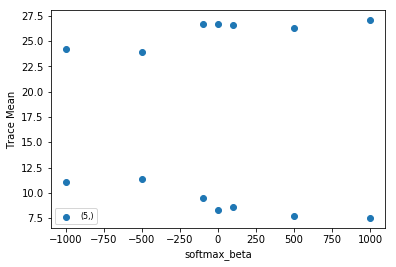

In [173]:

            
plot_stats(stats_df,  "softmax_beta", "Trace Mean", 
           filter_seperate=["sampling_tau"], filter_not_seperate=[], 
           X_axis_bounds=None)



In [167]:

            
plot_stats(stats_df,  "Train Loss Mean", "Trace Mean", filter_by=["softmax_beta"], seperate=False, )



TypeError: plot_stats() got an unexpected keyword argument 'filter_by'

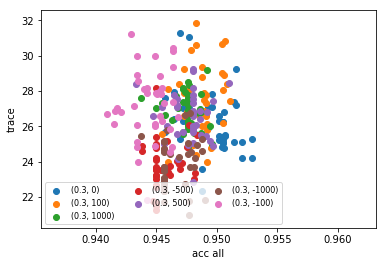

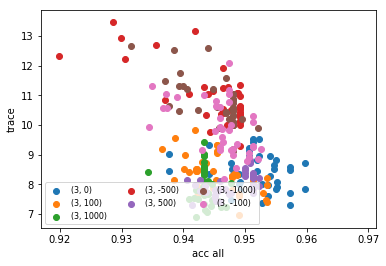

In [171]:
plot_special(exp_dict, "acc all", "trace",
               filter_seperate=["learning_rate"], filter_not_seperate=["softmax_beta"])


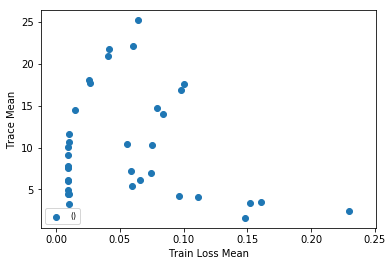

In [42]:

      
plot_stats(stats_df,  "Train Loss Mean", "Trace Mean",filter_by=[], seperate=True)



In [629]:
Y_val_exp

{'1589929772.7997508': None,
 '1589929772.7014642': None,
 '1589929773.263315': None}

1590060836.213588


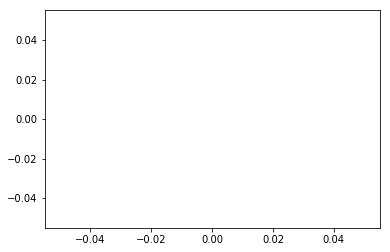

1590028572.1037078


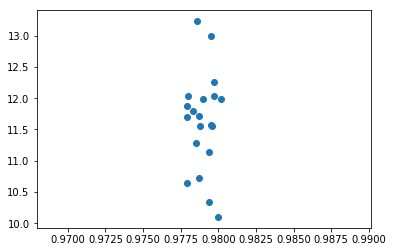

1590035144.78129


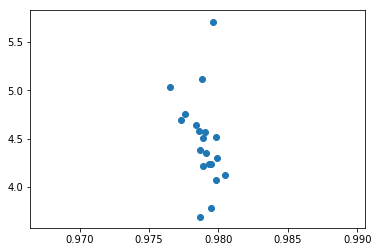

1590035091.965398


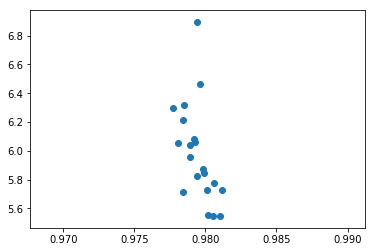

1590028565.0918689


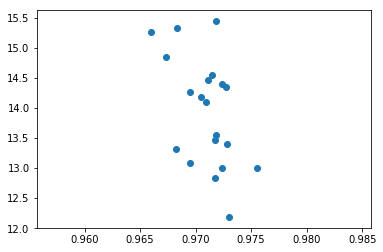

1590028566.324407


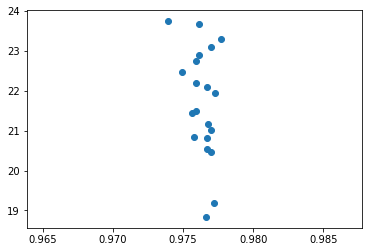

1590045173.231596


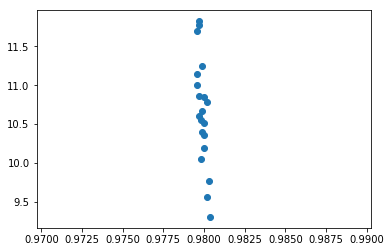

1590040480.7683399


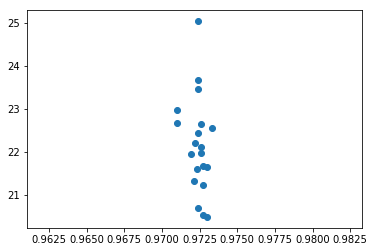

1590044996.8002229


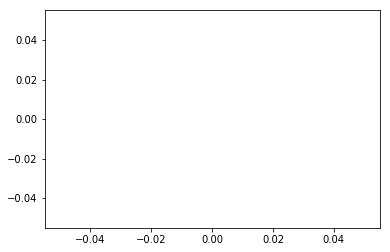

1590056201.264468


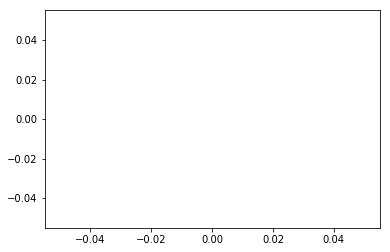

1590061151.2922392


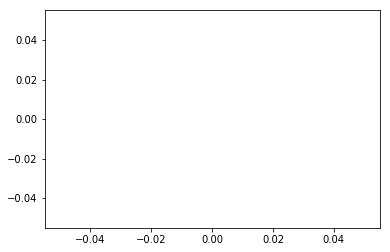

1590050877.5138009


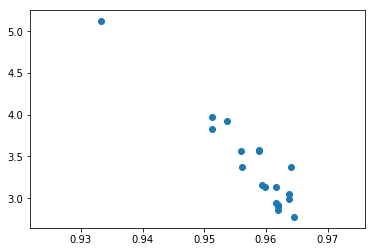

1590041496.330213


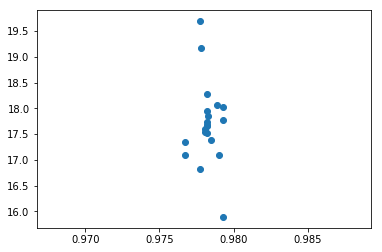

1590041139.107678


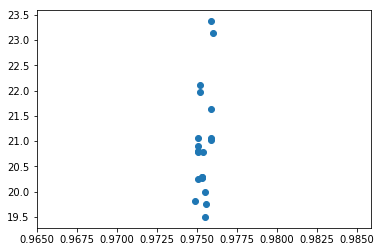

1590040026.3495731


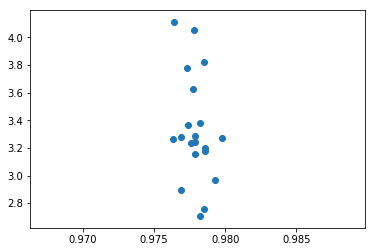

1590028572.766422


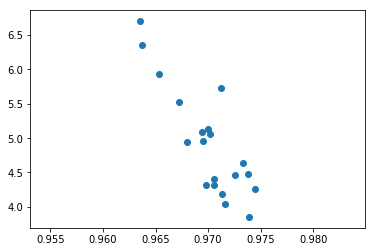

1590041027.966861


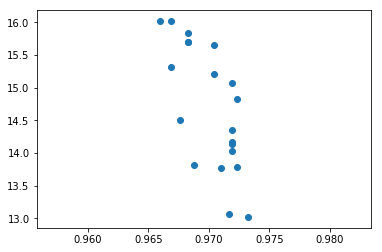

1590060328.7208698


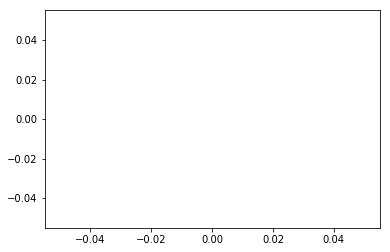

1590028568.512366


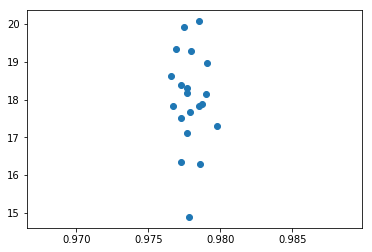

1590044009.2623098


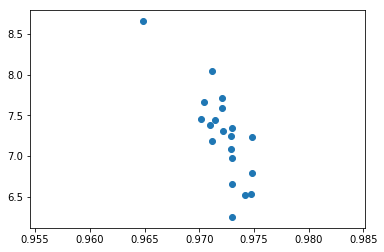

1590053699.660497


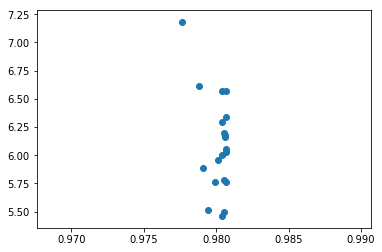

1590033973.8102221


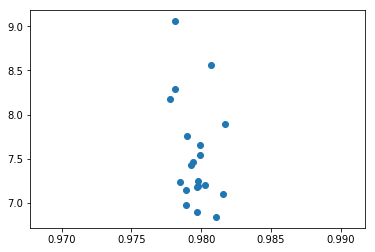

1590028570.450788


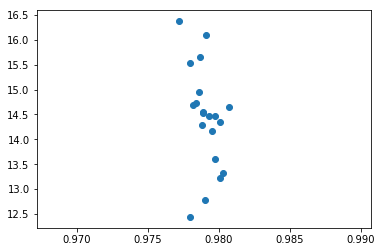

1590060331.36747


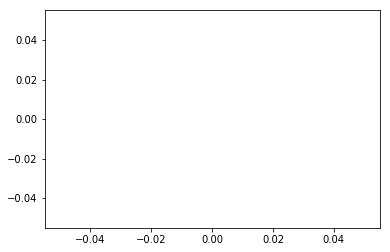

1590028563.8831859


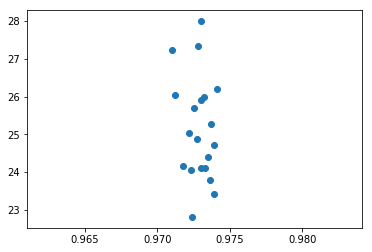

1590040224.397401


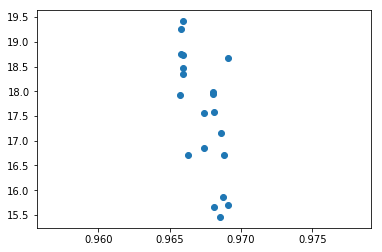

1590028571.363729


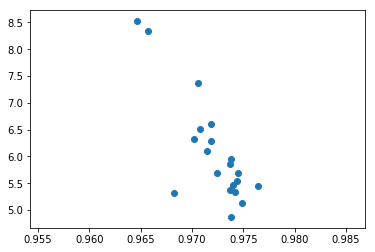

1590061314.9856079


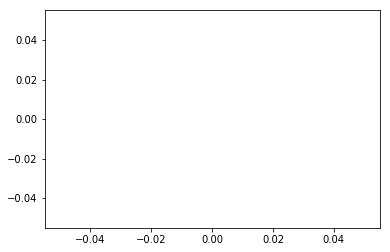

1590049787.032524


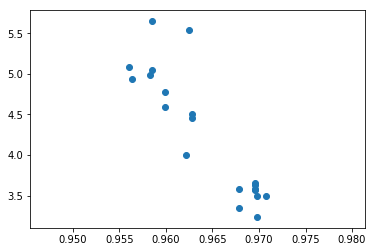

1590035133.027304


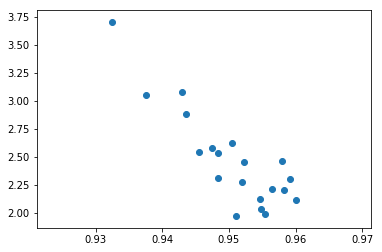

1590033717.515472


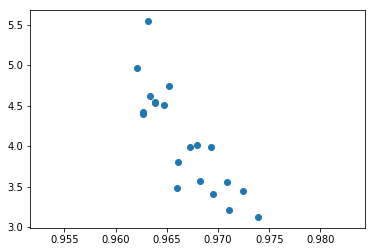

1590035091.707934


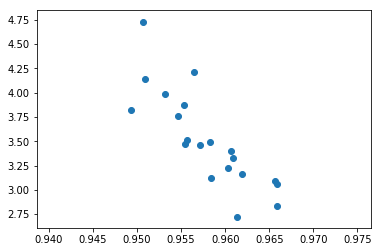

1590038011.787379


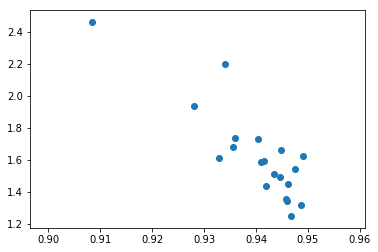

1590061232.082815


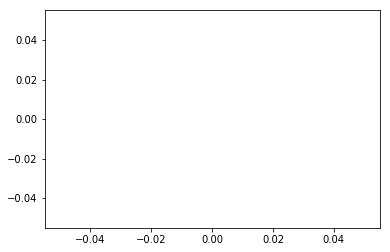

1590045174.302006


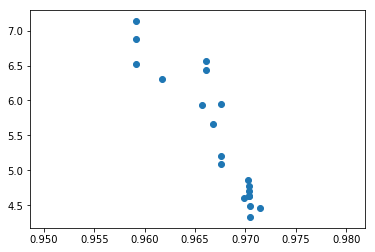

1590060386.307929


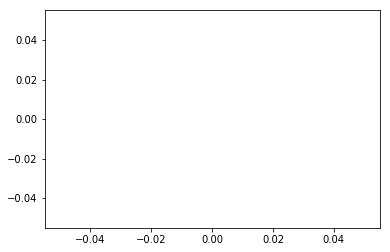

1590050599.035004


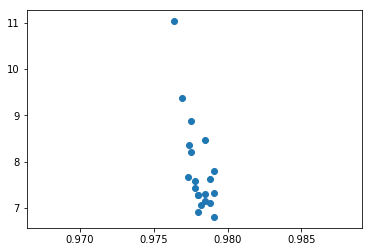

1590028562.749546


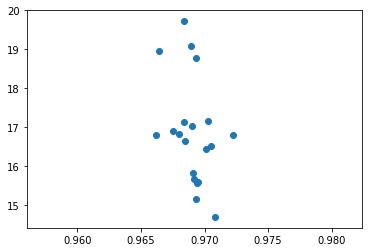

1590028567.6050649


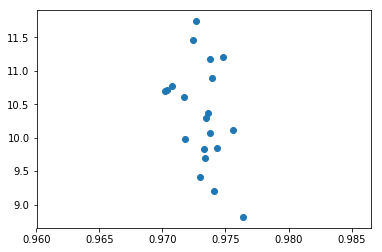

1590059361.444496


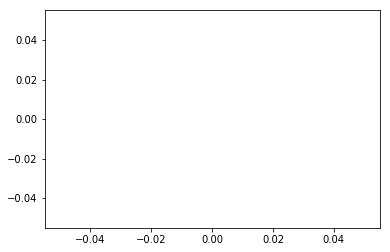

1590028573.3593879


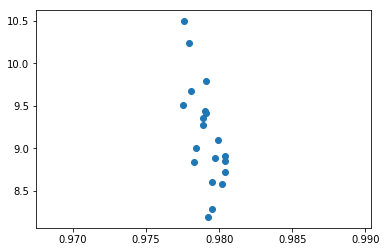

1590054788.947242


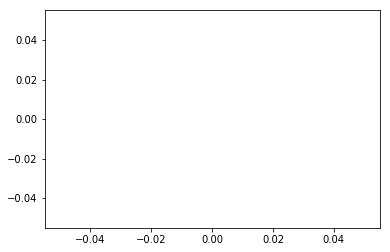

1590054859.480563


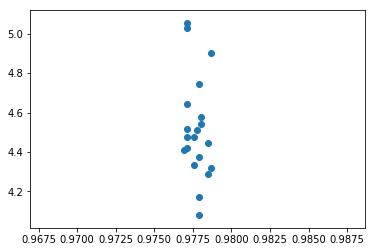

1590041326.4915998


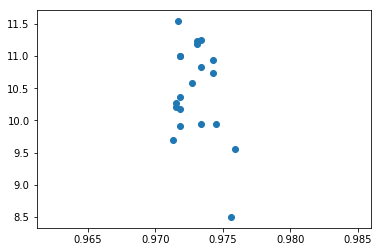

1590028569.491214


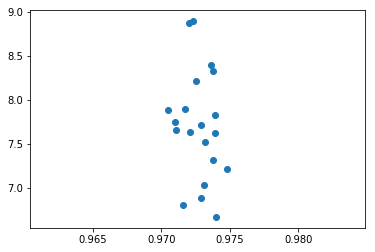

1590059516.801294


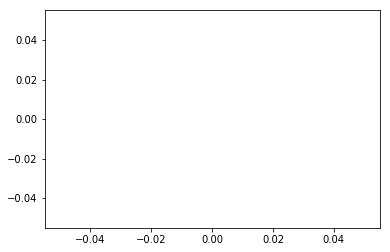

1590045173.2309718


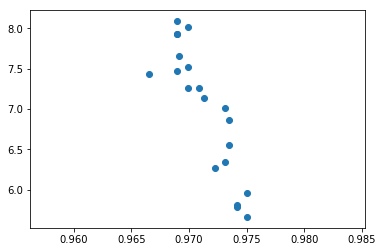

1590045177.104209


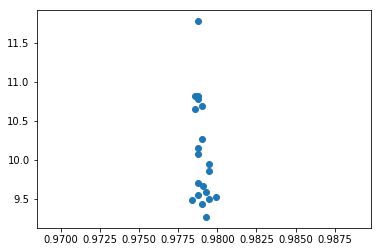

In [112]:
X_val_exp = get_stat_step(exp_dict, "Accuracy", -1, exp_ids= None)
Y_val_exp = get_stat_step(exp_dict, "trace", -1, exp_ids= None)

for i in X_val_exp:
    print(i)
    X_val = X_val_exp[i]
    Y_val = Y_val_exp[i]
    
    plt.scatter(X_val, Y_val)
    plt.show()

1590022753.515519
No Loss/train for step 1001
1590022753.515519


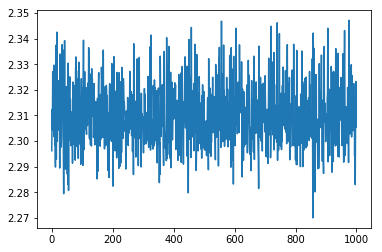

1590022752.489303
No Loss/train for step 1001
1590022752.489303


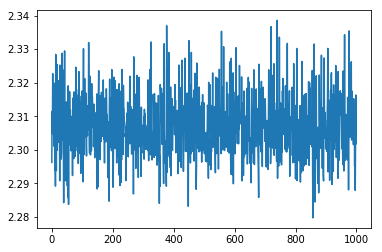

1590022755.429562
No Loss/train for step 1001
1590022755.429562


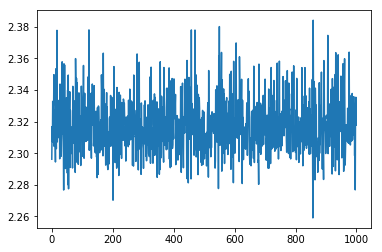

1590022754.341554
No Loss/train for step 1001
1590022754.341554


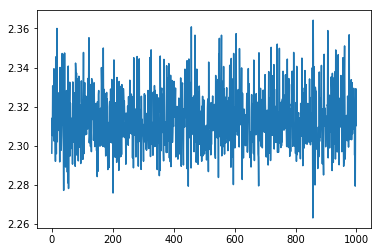

1590022758.695997
No Loss/train for step 1001
1590022758.695997


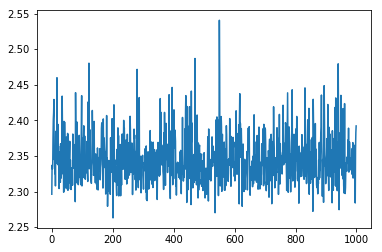

1590022757.064827
No Loss/train for step 1001
1590022757.064827


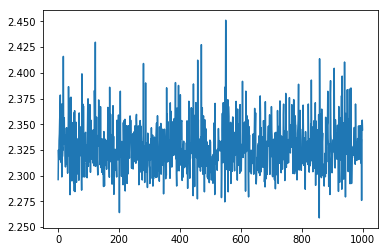

1590022759.355402
No Loss/train for step 1001
1590022759.355402


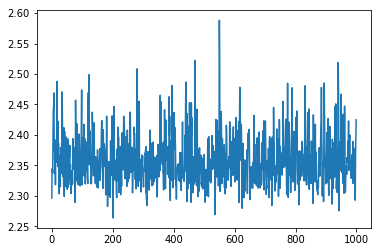

1590022751.532098
No Loss/train for step 1001
1590022751.532098


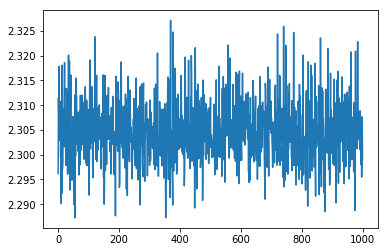

1590022756.209878
No Loss/train for step 1001
1590022756.209878


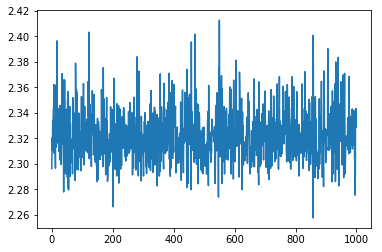

1590022757.841836
No Loss/train for step 1001
1590022757.841836


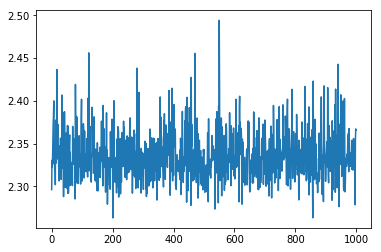

In [875]:
# exp_ids = stats_df.index[stats_df["learning_rate"] == 0.2672222222222222]
# print(exp_ids)
# kish = get_runs_plot(stuff["runs"], ["Kish"])
# weight_var_trace = get_runs_plot(stuff["runs"], ["WeightVarTrace"])
runs_plts = get_runs_plots(exp_dict, "Loss/train", exp_ids=None, seperate=True)



1589819806.776087
No Potential/curr for step 501
1589819806.776087


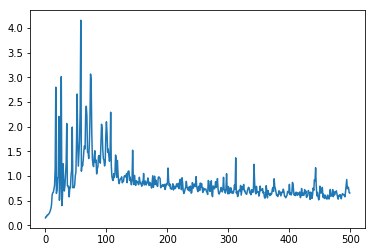

1589814421.4606469
No Potential/curr for step 501
1589814421.4606469


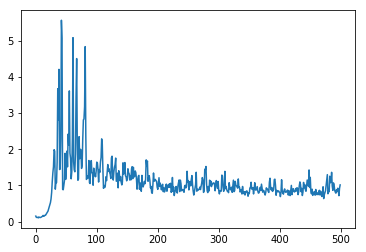

1589814412.117492
No Potential/curr for step 501
1589814412.117492


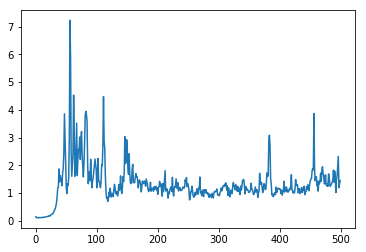

1589887025.0204642
No Potential/curr for step 501
1589887025.0204642


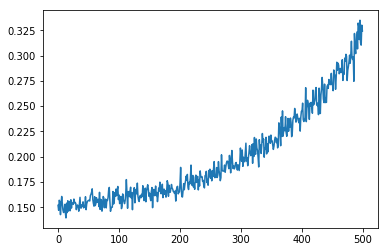

1589887035.8999512
No Potential/curr for step 501
1589887035.8999512


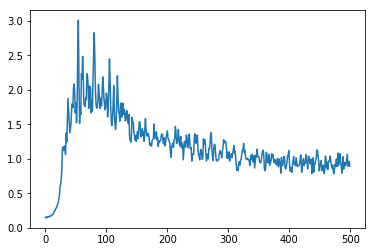

1589814398.9218051
No Potential/curr for step 501
1589814398.9218051


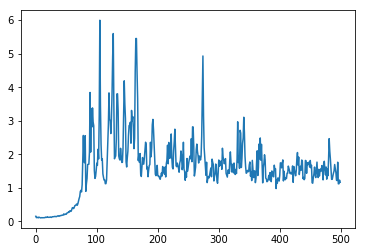

1589814387.69637
No Potential/curr for step 501
1589814387.69637


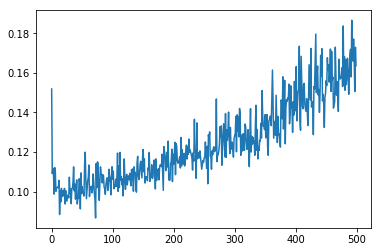

1589887033.6927738
No Potential/curr for step 501
1589887033.6927738


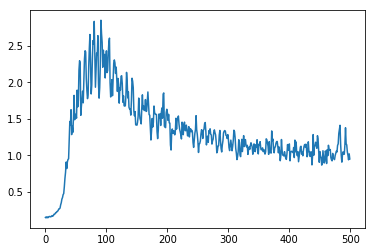

1589814418.413313
No Potential/curr for step 501
1589814418.413313


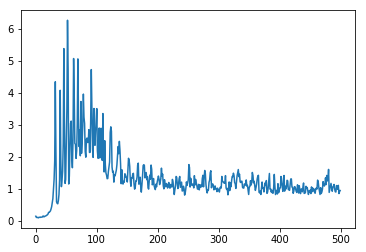

1589887048.527024
No Potential/curr for step 501
1589887048.527024


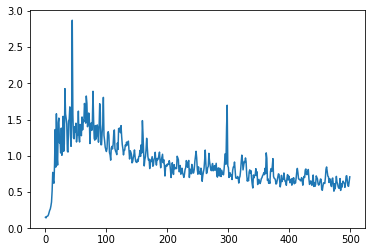

1589887039.065985
No Potential/curr for step 501
1589887039.065985


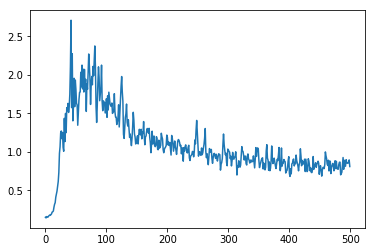

1589819805.338277
No Potential/curr for step 501
1589819805.338277


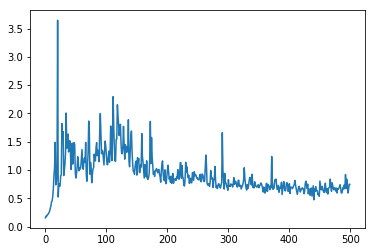

1589887030.106464
No Potential/curr for step 501
1589887030.106464


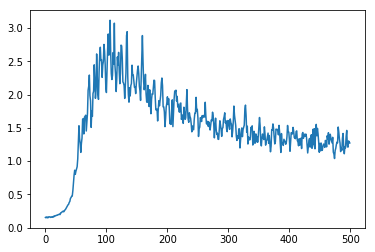

1589887043.626755
No Potential/curr for step 501
1589887043.626755


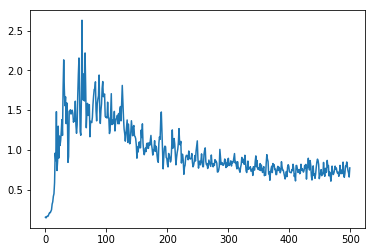

1589814391.9086988
No Potential/curr for step 501
1589814391.9086988


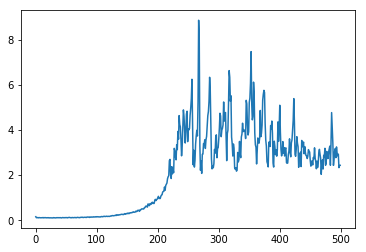

1589814403.79649
No Potential/curr for step 501
1589814403.79649


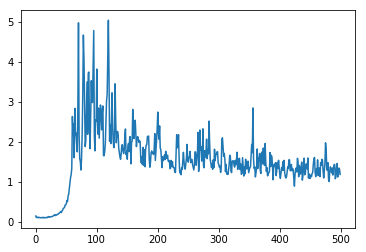

1589814408.634212
No Potential/curr for step 501
1589814408.634212


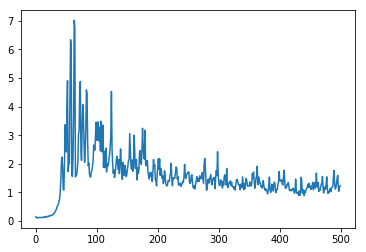

1589819799.163626
No Potential/curr for step 501
1589819799.163626


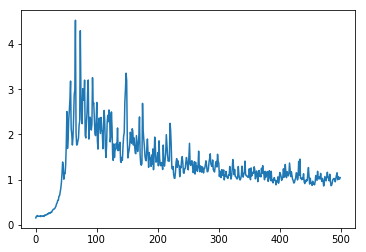

1589887026.9994838
No Potential/curr for step 501
1589887026.9994838


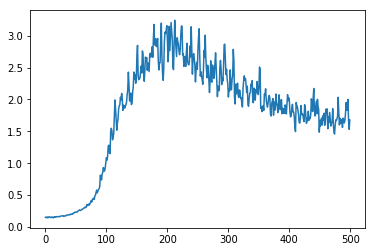

1589819820.3513489
No Potential/curr for step 501
1589819820.3513489


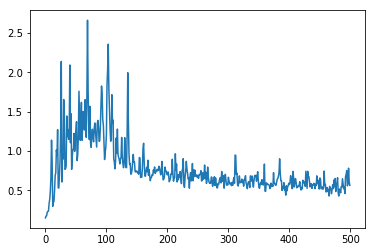

1589819798.6340742
No Potential/curr for step 501
1589819798.6340742


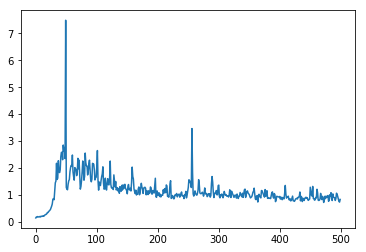

1589819801.5255191
No Potential/curr for step 501
1589819801.5255191


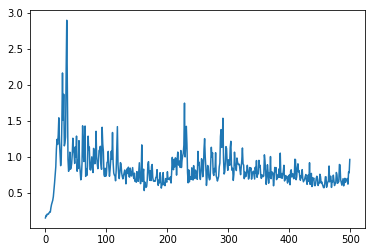

1589819812.19179
No Potential/curr for step 501
1589819812.19179


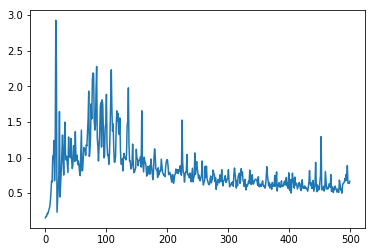

1589814394.674665
No Potential/curr for step 501
1589814394.674665


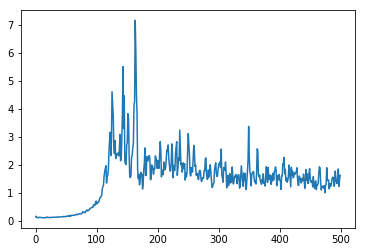

1589814415.122522
No Potential/curr for step 501
1589814415.122522


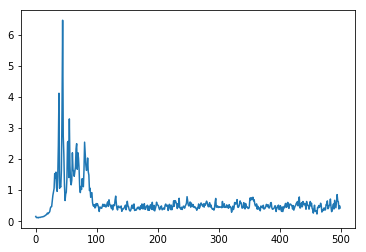

1589887046.41769
No Potential/curr for step 501
1589887046.41769


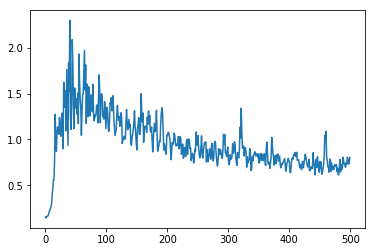

1589887040.990033
No Potential/curr for step 501
1589887040.990033


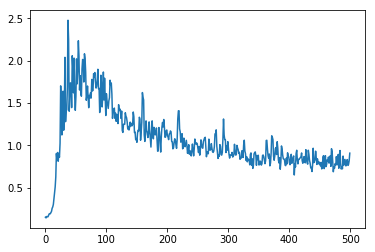

1589814426.004899
No Potential/curr for step 501
1589814426.004899


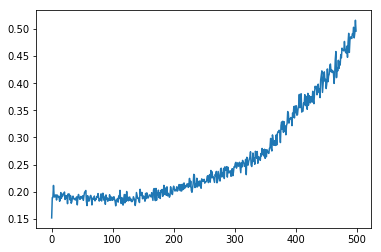

1589814428.149462
No Potential/curr for step 501
1589814428.149462


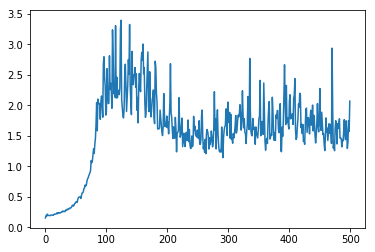

1589819799.649915
No Potential/curr for step 501
1589819799.649915


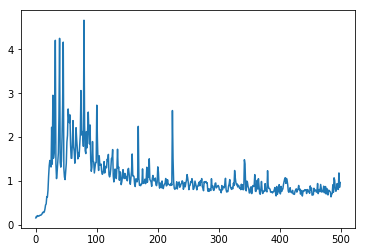

In [508]:


# kish = get_runs_plot(stuff["runs"], ["Kish"])
# weight_var_trace = get_runs_plot(stuff["runs"], ["WeightVarTrace"])

runs_plts = get_runs_plots(exp_dict, "Potential/curr", seperate=True)



In [ ]:
def sampling_plot_arr(values_arr, resampling_arr):
    p_dicts = []
    for p in range(len(values_arr)):
        curr_assigned_plot = p
        last_resampling = 0
        p_dicts.append({curr_assigned_plot: []})

        for t in range(len(values_arr[p])):
            if resampling_arr[t][p] != p:
                if (last_resampling == 0) and (curr_assigned_plot == p):
                    p_dicts[p][curr_assigned_plot].append([[last_resampling, t], values_arr[p][last_resampling:t+1]])
                else:
                    starts_at = values_arr[resampling_arr[last_resampling][p]][last_resampling]
                    p_dicts[p][curr_assigned_plot].append([[last_resampling, t], [starts_at] + values_arr[p][last_resampling+1:t+1]])

                curr_assigned_plot = resampling_arr[t][p]
                last_resampling = t
                if curr_assigned_plot not in p_dicts[p]:
                    p_dicts[p][curr_assigned_plot] = []
                
        if (last_resampling == 0) and (curr_assigned_plot == p):
            p_dicts[p][curr_assigned_plot].append([[last_resampling, t], values_arr[p][last_resampling:t+1]])
        else:
            starts_at = values_arr[resampling_arr[last_resampling][p]][last_resampling]
            p_dicts[p][curr_assigned_plot].append([[last_resampling, t], [starts_at] + values_arr[p][last_resampling+1:t+1]])

    return p_dicts

def sampling_plot(p_dicts):
    fig, axs = plt.subplots(len(p_dicts))
    fig.suptitle('Axes values are scaled individually by default')
    
    for p in range(len(p_dicts)):
        for curr_a in p_dicts[p]:
            for i in range(len(p_dicts[p][curr_a])):
                x_range, y_values = p_dicts[p][curr_a][i]
                if len(y_values) == 1:
                    print(

In [206]:
def sampling_plot_arr(values_arr, resampling_arr):
    p_dicts = []
    for p in range(len(values_arr)):
        curr_assigned_plot = p
        last_resampling = 0
        p_dicts.append({curr_assigned_plot: []})

        for t in range(len(values_arr[p])):
            if resampling_arr[t][p] != p:
                if (last_resampling == 0) and (curr_assigned_plot == p):
                    p_dicts[p][curr_assigned_plot].append([[last_resampling, t], values_arr[p][last_resampling:t+1]])
                else:
                    starts_at = values_arr[resampling_arr[last_resampling][p]][last_resampling]
                    p_dicts[p][curr_assigned_plot].append([[last_resampling, t], [starts_at] + values_arr[p][last_resampling+1:t+1]])

                curr_assigned_plot = resampling_arr[t][p]
                last_resampling = t
                if curr_assigned_plot not in p_dicts[p]:
                    p_dicts[p][curr_assigned_plot] = []
                
        if (last_resampling == 0) and (curr_assigned_plot == p):
            p_dicts[p][curr_assigned_plot].append([[last_resampling, t], values_arr[p][last_resampling:t+1]])
        else:
            starts_at = values_arr[resampling_arr[last_resampling][p]][last_resampling]
            p_dicts[p][curr_assigned_plot].append([[last_resampling, t], [starts_at] + values_arr[p][last_resampling+1:t+1]])

    return p_dicts

def sampling_plot(p_dicts):
    fig, axs = plt.subplots(len(p_dicts))
    fig.suptitle('Axes values are scaled individually by default')
    
    for p in range(len(p_dicts)):
        for curr_a in p_dicts[p]:
            for i in range(len(p_dicts[p][curr_a])):
                x_range, y_values = p_dicts[p][curr_a][i]
                if len(y_values) == 1:
                    print(p_dicts[p])
                    axs[curr_a].scatter(list(range(x_range[0], x_range[1] + 1)), y_values)
                else:
                    axs[curr_a].plot(list(range(x_range[0], x_range[1] + 1)), y_values)



[{0: [[[0, 0], [1]]], 1: [[[0, 1], [5, 2]], [[3, 3], [8]]], 2: [[[1, 3], [10, 3, 4]]]}, {1: [[[0, 0], [5]]], 0: [[[0, 1], [1, 6]], [[1, 3], [2, 7, 8]]]}, {2: [[[0, 3], [9, 10, 11, 12]]]}]
{0: [[[0, 0], [1]]], 1: [[[0, 1], [5, 2]], [[3, 3], [8]]], 2: [[[1, 3], [10, 3, 4]]]}
{0: [[[0, 0], [1]]], 1: [[[0, 1], [5, 2]], [[3, 3], [8]]], 2: [[[1, 3], [10, 3, 4]]]}
{1: [[[0, 0], [5]]], 0: [[[0, 1], [1, 6]], [[1, 3], [2, 7, 8]]]}


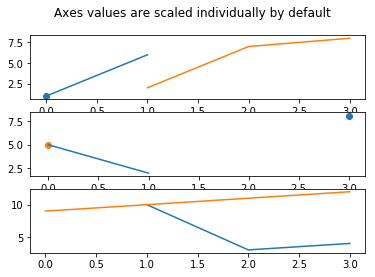

In [210]:
vs = [[1,2,3,4], [5,6,7,8], [9, 10, 11, 12]]
rs = [[1, 0, 2], [2, 0, 2], [0,1, 2], [1, 1, 2]]

s = sampling_plot_arr(vs, rs)
print(s)
sampling_plot(s)

No Potential/total for step 0
{0: [[[0, 0], array([0.1770224])]], 4: [[[0, 1], array([0.33240567])], [[20, 21], array([2.49645972])], [[25, 26], array([1.28394002])], [[64, 65], array([1.03889444])], [[103, 104], array([0.98112103])]], 39: [[[1, 2], array([0.31604916])]], 28: [[[2, 4], array([0.38251606, 0.36369875])], [[32, 33], array([1.61276615])], [[68, 69], array([1.23052442])]], 6: [[[4, 5], array([0.63296166])], [[81, 82], array([0.86998388])], [[93, 94], array([0.74539305])]], 30: [[[5, 6], array([0.6416783])], [[18, 19], array([1.54597384])]], 14: [[[6, 7], array([0.74168783])], [[39, 40], array([1.09853309])]], 26: [[[7, 8], array([0.89268947])], [[17, 18], array([1.59851474])], [[97, 98], array([0.64959311])], [[107, 108], array([0.78916663])]], 16: [[[8, 9], array([0.98087084])], [[15, 16], array([1.50363976])], [[53, 54], array([1.2752133])], [[63, 64], array([0.94940689])], [[110, 111], array([1.09587467])], [[111, 112], array([0.74477082])]], 37: [[[9, 10], array([1.5462

ValueError: x and y must be the same size

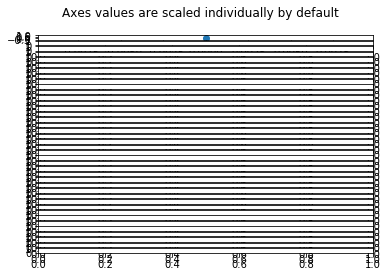

In [208]:
exp_runs = exp_dict["stuff"]["runs"]
var_name = "Potential/total"
running_average_gamma = 1
for exp in exp_runs:
    res_idx = exp_dict["resampling_idxs"][exp]
    res_idx_arr = []
    # indexing is because we save before and after training
    for t in range(1, len(res_idx) - 1):
        res_idx_arr.append(res_idx[str(t)])
    

    val_list = None

    for t in range(len(exp_runs[exp])):
        try:
            # going down the tree with node names given by var_name.split("/")
            curr_dict = exp_runs[exp][t]
            var_name_split = var_name.split("/")
            for n in var_name_split:
                curr_dict = curr_dict[n]

            if "net" in curr_dict:
                num_nets = int(max(curr_dict["net"], key=lambda x: int(x))) + 1  # +1 bc zero indexed
                to_append = np.array([curr_dict["net"][str(nn)] for nn in range(num_nets)])
                # to_append = np.mean(to_append)

            else:
                to_append = curr_dict[""]
            if val_list is None:
                val_list = [to_append]
            else:
                to_append = val_list[-1] * (1 - running_average_gamma) + running_average_gamma * to_append
                val_list.append(to_append)
        except:
            print("No {} for step {}".format(var_name, t))
    s_plot_dicts = sampling_plot_arr(np.array(val_list).T, res_idx_arr)
    sampling_plot(s_plot_dicts)

# Analysis 

Plots (FUNCTION):
ACC vs Trace
Train Loss vs Trace
ACC vs Train loss
Mean/COV ACC -- MEAN/COV TRACE -- MEAN/COV TRAIN LOSS (CORRELATIONS FOR ALL OF THESE)


Plot weightspace and input space 

In [175]:
# next step, get accuracy here... sucks we can't get it otherwise

In [171]:
configs = get_configs(experiment_folder)
config_to_id_map = get_config_to_id_map(configs)
ids = get_ids(config_to_id_map, config)

NameError: name 'config' is not defined

In [161]:
config = {'batch_test_size': 100,
 'batch_train_size': 16,
 'ess_threshold': None,
 'learning_rate': 0.001,
 'momentum': 0,
 'net_name': 'SimpleNet',
 'net_params': None, #[2, 2, 256, 1],
 'num_steps': 100,
 'num_nets': 100,
 'softmax_beta': None, #0,
 'torch_random_seed': 1,
 'sampling_tau': None,
 'weight_type': 'loss_gradient_weights'}

In [ ]:
import time

In [ ]:
for i in sorted(tsne_dict):
    print(i)
    plt.scatter(tsne_dict[i][:, 0], tsne_dict[i][:, 1])
    plt.show()
    

In [ ]:
tsne_dict = get_tsne_dict(experiment_folder, curr_dir)
for i in sorted(tsne_dict):
    print(i)
    plt.scatter(tsne_dict[i][:, 0], tsne_dict[i][:, 1])
    plt.show()

In [ ]:


models, sampled_idx = get_models(os.path.join(experiment_folder, "resampling", curr_dir), 0)
models_vecs = np.array([get_params_vec(m) for m in models.values()])

shortest_distance = float("inf")
shortest_pair = (None, None)

largest_distance = -float("inf")
largest_pair = (None, None)
for i in range(len(models_vecs)):
    for j in range(i + 1, len(models_vecs)):
        if np.linalg.norm(models_vecs[i] - models_vecs[j]) < shortest_distance:
            shortest_distance = np.linalg.norm(models_vecs[i] - models_vecs[j])
            shortest_pair = (i, j)
        if np.linalg.norm(models_vecs[i] - models_vecs[j]) > largest_distance:
            largest_distance = np.linalg.norm(models_vecs[i] - models_vecs[j])
            largest_pair = (i, j)


In [ ]:
shortest_distance

In [ ]:
largest_distance
np.linalg.norm(models_vecs[0])

In [ ]:
with open(os.path.join(experiment_folder, "data.pkl"), "rb") as f:
    data = pickle.load(f)

train_loader = DataLoader(data[0], batch_size=len(data[0]), shuffle=True)  # fix the batch size
test_loader = DataLoader(data[1], batch_size=len(data[1]))

largest_arr = []
largest_acc = []
shortest_arr = []
shortest_acc = []

largest_mags = []
shortest_mags = []

step_dir = get_all_model_steps(os.path.join(experiment_folder, "resampling", curr_dir))
for step in sorted(step_dir):
    print(step)
    models, sampled_idx = get_models(os.path.join(experiment_folder, "resampling", curr_dir), step)
    models_vecs = np.array([get_params_vec(m) for m in models.values()])
    
    largest_arr.append(np.linalg.norm(models_vecs[largest_pair[0]] - models_vecs[largest_pair[1]]))
    shortest_arr.append(np.linalg.norm(models_vecs[shortest_pair[0]] - models_vecs[shortest_pair[1]]))
    
    largest_acc.append([get_net_accuracy(models[str(largest_pair[0])], test_loader), get_net_accuracy(models[str(largest_pair[1])], test_loader)])
    shortest_acc.append([get_net_accuracy(models[str(shortest_pair[0])], test_loader), get_net_accuracy(models[str(shortest_pair[1])], test_loader)])


    largest_mags.append([np.linalg.norm(models_vecs[largest_pair[0]]), np.linalg.norm(models_vecs[largest_pair[1]])])
    shortest_mags.append([np.linalg.norm(models_vecs[shortest_pair[0]]),np.linalg.norm(models_vecs[shortest_pair[1]])])

In [ ]:
plt.plot(list(sorted(step_dir)), largest_arr )
plt.show()
plt.plot(list(sorted(step_dir)), np.array(largest_acc)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(largest_acc)[:, 1])
plt.show()

plt.plot(list(sorted(step_dir)), np.array(shortest_acc)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(shortest_acc)[:, 1])
plt.show()


plt.plot(list(sorted(step_dir)), np.array(largest_mags)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(largest_mags)[:, 1])
plt.show()

plt.plot(list(sorted(step_dir)), np.array(shortest_mags)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(shortest_mags)[:, 1])
plt.show()

In [90]:


all_dist = {}
for i in range(len(models)):
    for j in range(i+1, len(models)):
        a = get_params_vec(models[str(i)])
        b = get_params_vec(models[str(j)])

        all_dist[(i, j)] = torch.norm(a - b)

In [91]:
all_dist

{(0, 1): tensor(16.6315, grad_fn=<NormBackward0>),
 (0, 2): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 3): tensor(0.0025, grad_fn=<NormBackward0>),
 (0, 4): tensor(16.6317, grad_fn=<NormBackward0>),
 (0, 5): tensor(0.0025, grad_fn=<NormBackward0>),
 (0, 6): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 7): tensor(0.0040, grad_fn=<NormBackward0>),
 (0, 8): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 9): tensor(0.0032, grad_fn=<NormBackward0>),
 (0, 10): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 11): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 12): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 13): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 14): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 15): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 16): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 17): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 18): tensor(0.0022, grad_fn=<NormBackward0>),
 (0, 19): tensor(16.6315, grad_fn=<NormBackward0>),
 (0, 20): tensor(0.0025, g

In [94]:
models_vecs = np.array([get_params_vec(m).detach().numpy() for m in models.values()])

X_embedded = TSNE(n_components=2).fit_transform(models_vecs)

[]

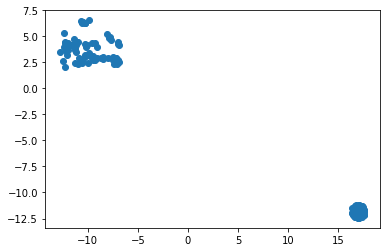

In [96]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.plot()

In [109]:
m = models[str(0)]
grad_steps= []
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # fix the batch size

for data in train_loader:
    inputs, labels = data
    # Compute gradients for input.
    inputs.requires_grad = True

    # forward + backward + optimize
    outputs = m(inputs)
    loss = criterion(outputs.float(), labels)
    loss.backward(retain_graph=True)
    
    grad_steps.append(get_grad_params_vec(m).detach().numpy())

In [110]:
u, s, vh = np.linalg.svd(np.array(grad_steps), full_matrices=False)

array([7.4566307e+01, 4.2778692e+00, 3.0374603e+00, 9.4402808e-01,
       3.5643500e-01, 2.0473388e-01, 1.5873392e-01, 1.1142698e-01,
       9.3603715e-02, 7.8027248e-02, 6.5044165e-02, 6.0796760e-02,
       4.8285898e-02, 3.8336921e-02, 3.6647409e-02, 3.3087600e-02,
       2.9207643e-02, 2.3398781e-02, 2.1899553e-02, 2.1008376e-02,
       1.7819939e-02, 1.6101249e-02, 1.4436195e-02, 1.2744365e-02,
       1.1394381e-02, 1.0279431e-02, 9.7109778e-03, 9.3411161e-03,
       8.4276162e-03, 8.1074052e-03, 7.4696536e-03, 6.8786601e-03],
      dtype=float32)

In [ ]:
mnist_data = get_